## Model: SARIMA
## Author: Justin Bloesch

In [1]:
import numpy as np
import pandas as pd
import warnings
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_squared_error
from math import sqrt
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib.dates as dates

pd.set_option('display.max_colwidth', None)
pd. set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
#Load SA Demand data set
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [3]:
#Check data set load
#demand_sa_df.head(2)
demand_sa_df.tail(2)

,DATETIME,TOTALDEMAND,REGIONID
196510,2021-03-17 23:30:00,1194.34,SA1
196511,2021-03-18 00:00:00,1340.58,SA1


In [4]:
#Convert DATETIME string to type datetime 
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

#Break down Timestamp into new attributes
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month

In [5]:
#Get winter 2019 data for model build
demand_sa_2019_df = demand_sa_df.loc[(demand_sa_df['YEAR'] == 2019)].reset_index()
demand_sa_winter_2019_df = demand_sa_2019_df.loc[(demand_sa_2019_df['MONTH'] == 6) | (demand_sa_2019_df['MONTH'] == 7) | (demand_sa_2019_df['MONTH'] == 8) ].reset_index()

In [6]:
#Check winter 2019 data subset
#demand_sa_winter_2019_df.head(2)
#demand_sa_winter_2019_df.tail(2)
#demand_sa_winter_2019_df.MONTH.unique()
demand_sa_winter_2019_df.shape

(4416, 7)

In [7]:
#Augmented Dickey-Fuller test for (non)stationary
ad_fuller_result = adfuller(demand_sa_winter_2019_df['TOTALDEMAND'], autolag='AIC')
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'Number of lags: {ad_fuller_result[1]}')
print(f'p-value: {ad_fuller_result[1]}')
for key, value in ad_fuller_result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')
print(f'Result: The Demand series is {"not " if ad_fuller_result[1] > 0.05 else ""}stationary')

ADF Statistic: -9.735277035041369
Number of lags: 8.784011012629781e-17
p-value: 8.784011012629781e-17
Critial Values:
   1%, -3.431842162413052
Critial Values:
   5%, -2.8621993540813637
Critial Values:
   10%, -2.567120978470452
Result: The Demand series is stationary


In [8]:
# KPSS test
from statsmodels.tsa.stattools import kpss
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(demand_sa_winter_2019_df['TOTALDEMAND']) #Test stationary around the mean
print('\n')
kpss_test(demand_sa_winter_2019_df['TOTALDEMAND'], regression='ct') #Test stationary around a trend

KPSS Statistic: 0.11376406348737442
p-value: 0.1
num lags: 36
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is stationary


KPSS Statistic: 0.10246174266472237
p-value: 0.1
num lags: 36
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is stationary


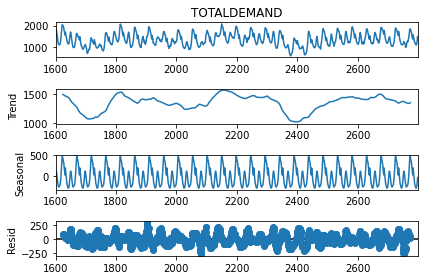

In [9]:
#Decompose time series (additive) across the whole data set
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[1600:2800], model='additive', period=48)
result_add.plot()
plt.show()

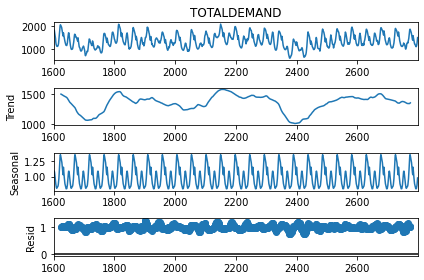

In [10]:
#Decompose time series (additive) across the whole data set
result_add = seasonal_decompose(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[1600:2800], model='multiplicative', period=48)
result_add.plot()
plt.show()

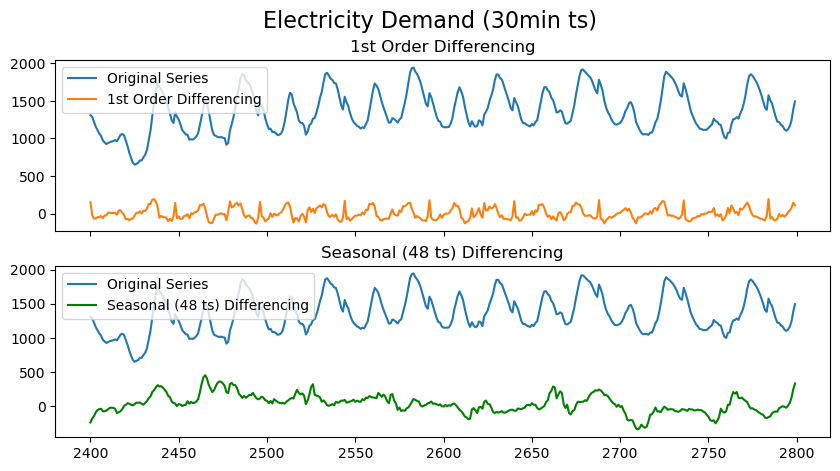

In [11]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# 1st Order Differencing
axes[0].plot(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], label='Original Series')
axes[0].plot(demand_sa_winter_2019_df['TOTALDEMAND'].diff(1).iloc[2400:2800].dropna(), label='1st Order Differencing')
axes[0].set_title('1st Order Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing (48 time steps (24hrs))
axes[1].plot(demand_sa_winter_2019_df['TOTALDEMAND'].iloc[2400:2800], label='Original Series')
axes[1].plot(demand_sa_winter_2019_df['TOTALDEMAND'].diff(48).iloc[2400:2800].dropna(), label='Seasonal (48 ts) Differencing', color='green')
axes[1].set_title('Seasonal (48 ts) Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Electricity Demand (30min ts)', fontsize=16)
plt.show()

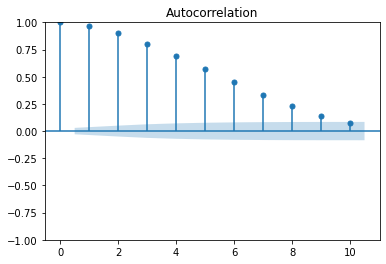

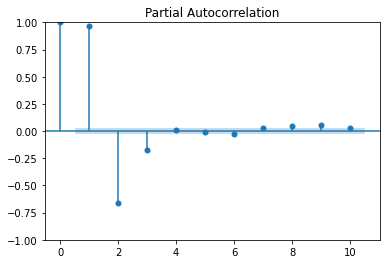

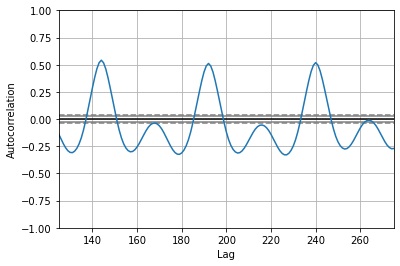

In [12]:
plot_acf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plot_pacf(demand_sa_winter_2019_df['TOTALDEMAND'], lags=10, alpha=0.05)
plt.show()

autocorrelation_plot(demand_sa_winter_2019_df['TOTALDEMAND'])
plt.xlim([125, 275])
plt.show()

In [13]:
#If the autocorrelations are positive for many number of lags (10 or more), then the series needs further differencing. 
#On the other hand, if the lag 1 autocorrelation itself is too negative, then the series is probably over-differenced.

#In the event, you can’t really decide between two orders of differencing, then go with the order that gives the least standard
#deviation in the differenced series.

#Fix differencing at 1

#Partial autocorrection plot demonstrates lag after which most lags are not significant, p=4
#Order of Integration I(d) represents the number of differences required to make the series stationary, d=0
#Moving average model MA(q), biggest lag after which other lags are not significant, q=10

#Seasonality S(P,D,Q,s)
#Seasonal length s=48
#D Order of seasonal integration representing the number of differences to remove seasonalit and any non-stationary behaviours (2?).

#large, high resolution time series. Due to the nature of how the ACF and PACF confidence limits are calculated in statsmodels1
#such a large time series will result in incredibly small values, resulting in the confidence intervals being basically 
#invisible.

In [32]:
#Grid search hyperparameters SARIMA(p,d,q)x(P,D,Q,s)
sarima_fit = auto_arima(demand_sa_winter_2019_df['TOTALDEMAND'], start_p=3, start_q=1, max_p=4, max_q=4,
                       m=48, stationary=True, start_P=0, seasonal=True, D=None, alpha=0.05, test='kpss', stepwise=True, information_criterion='aic',
                       n_jobs=1, method='lbfgs', suppress_warnings=True, trace=True, random_state=13, n_fits=25)

Performing stepwise search to minimize aic
 ARIMA(3,0,1)(0,0,1)[48] intercept   : AIC=46578.006, Time=54.76 sec
 ARIMA(0,0,0)(0,0,0)[48] intercept   : AIC=63261.905, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[48] intercept   : AIC=inf, Time=47.19 sec
 ARIMA(0,0,1)(0,0,1)[48] intercept   : AIC=inf, Time=20.51 sec
 ARIMA(0,0,0)(0,0,0)[48]             : AIC=76779.513, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[48] intercept   : AIC=48140.067, Time=1.49 sec
 ARIMA(3,0,1)(1,0,1)[48] intercept   : AIC=45291.793, Time=79.95 sec
 ARIMA(3,0,1)(1,0,0)[48] intercept   : AIC=inf, Time=81.56 sec
 ARIMA(3,0,1)(2,0,1)[48] intercept   : AIC=inf, Time=331.12 sec
 ARIMA(3,0,1)(1,0,2)[48] intercept   : AIC=45186.619, Time=422.59 sec
 ARIMA(3,0,1)(0,0,2)[48] intercept   : AIC=45850.511, Time=247.11 sec
 ARIMA(3,0,1)(2,0,2)[48] intercept   : AIC=inf, Time=347.01 sec
 ARIMA(2,0,1)(1,0,2)[48] intercept   : AIC=45743.940, Time=319.88 sec
 ARIMA(3,0,0)(1,0,2)[48] intercept   : AIC=44948.723, Time=286.07 sec
 ARIMA(3,0,0)(0,0,

In [33]:
#SARIMA model fit summary
sarima_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                 4416
Model:             SARIMAX(3, 0, 0)x(1, 0, [1], 48)   Log Likelihood              -22168.849
Date:                              Sat, 19 Mar 2022   AIC                          44351.699
Time:                                      23:42:40   BIC                          44396.450
Sample:                                           0   HQIC                         44367.482
                                             - 4416                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      9.9602      0.926     10.752      0.000       8.145      11.776
ar.L1          1.2303      0.013     96.272      0.000       1.205       1.255
ar.L2         -0.0953      0.020     -4.656      0.000      -0.135      -0.055
ar.L3         -0.1961      0.012    -15.794      0.000      -0.220      -0.172
ar.S.L48       0.8671      0.008    111.259      0.000       0.852       0.882
ma.S.L48      -0.4621      0.018    -25.867      0.000      -0.497      -0.427
sigma2      1416.9016     24.000     59.037      0.000    1369.862    1463.941
===================================================================================
Ljung-Box (L1) (Q):                  49.27   Jarque-Bera (JB):              1509.65
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
#Get preceding winter training data up to 7 Aug 0400 hrs 2020
iloc = (demand_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (demand_sa_df['DATETIME'] <= '2020-08-07 04:00:00')

#Create and capture winter training demand 2020
demand_sa_train_winter = demand_sa_df.loc[iloc]

In [15]:
#Build final SARIMA model
model = ARIMA(demand_sa_train_winter['TOTALDEMAND'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model_fit = model.fit()

In [16]:
#summary of fitted model
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        TOTALDEMAND   No. Observations:                 3225
Model:             ARIMA(3, 0, 0)x(1, 0, [1], 48)   Log Likelihood              -15561.205
Date:                            Tue, 05 Apr 2022   AIC                          31136.411
Time:                                    12:57:25   BIC                          31178.961
Sample:                                         0   HQIC                         31151.660
                                           - 3225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1505.7275    147.516     10.207      0.000    1216.601    1794.854
ar.L1          1.4723      0.013    111.773      0.000       1.446       1.498
ar.L2         -0.4366      0.022    -19.891      0.000      -0.480      -0.394
ar.L3         -0.0675      0.013     -5.191      0.000      -0.093      -0.042
ar.S.L48       0.9996      0.000   7126.468      0.000       0.999       1.000
ma.S.L48      -0.9476      0.008   -125.671      0.000      -0.962      -0.933
sigma2       862.9511     14.063     61.363      0.000     835.388     890.514
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):              2191.67
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.01
Prob(H) (two-sided):                  0.16   Kurtosis:                         7.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

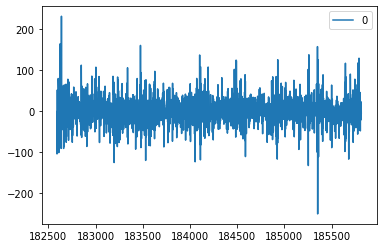

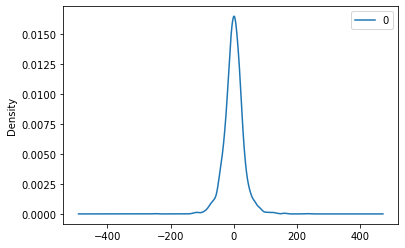

                 0
count  3225.000000
mean      0.002539
std      30.501847
min    -250.554057
25%     -15.907822
50%       0.260810
75%      16.327363
max     231.044662


In [17]:
#Check Residuals
#line plot of residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

#Density Plot of residuals
residuals.plot(kind='kde')
plt.show()

#summary stats of residuals
print(residuals.describe())

In [18]:
print(durbin_watson(residuals)) 

[1.98690426]


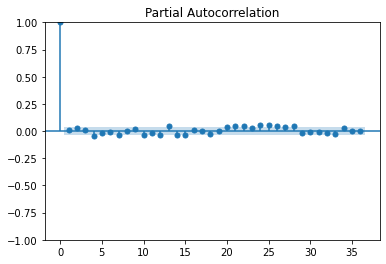

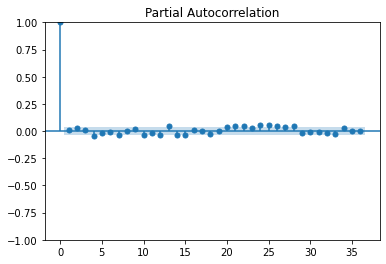

In [19]:
plot_pacf(residuals)

In [20]:
#Model residuals
#1. Zero mean assumed. No remaining trend in the data
#2. Uncorrelated assumed. Durbin_watson test of 2 indicates no autocorrelation (stationary). 
#   0-2 positive autocorrelation. 2-3 negative autocorrelation.
#3. residuals guassian distributed assumed with mean zero
#4. Residual diagnostics looks like a white noise. Autocorrelations is between the two blue lines and it meets all 
#our criteria for a good forecast and prediction.

In [21]:
#Forecast 48 30min time steps
forecast_48_ts = model_fit.get_forecast(48, alpha=0.05).summary_frame()
print(forecast_48_ts)

TOTALDEMAND         mean     mean_se  mean_ci_lower  mean_ci_upper
3225         1332.589590   29.377099    1275.011534    1390.167647
3226         1323.090767   52.285605    1220.612864    1425.568669
3227         1328.964120   72.938166    1186.007940    1471.920299
3228         1361.091938   90.755358    1183.214704    1538.969172
3229         1413.233633  105.804189    1205.861232    1620.606033
3230         1512.994819  118.363906    1281.005826    1744.983811
3231         1617.258594  128.776662    1364.860974    1869.656213
3232         1730.601326  137.378578    1461.344261    1999.858391
3233         1814.951752  144.472436    1531.790980    2098.112524
3234         1795.612440  150.319412    1500.991807    2090.233073
3235         1694.931165  155.139456    1390.863418    1998.998912
3236         1587.883228  159.115275    1276.023020    1899.743437
3237         1465.894220  162.397440    1147.601087    1784.187354
3238         1348.784476  165.109513    1025.175776    1672.39

In [22]:
#Get 48 time steps of actual demand to compare to winter forecast
iloc = ((demand_sa_df['DATETIME'] > '2020-08-07 04:00:00')) 

#Generate and capture 48 time steps of demand greater than forecast data
actual_demand_winter_2020_sa_df = demand_sa_df.loc[iloc]
actual_demand_winter_2020_sa_48_ts_df = actual_demand_winter_2020_sa_df.head(48)

#Generate time string for plotting
actual_demand_winter_2020_sa_48_ts_df['TIMEstrg'] = actual_demand_winter_2020_sa_48_ts_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

In [23]:
#Prepare demand forecast data for plotting

#Get actual demand from 01.08.2020 0400 hrs til final prediction forcast time 08.08.2020 0400 hrs
iloc = (demand_sa_df['DATETIME'] >= '2020-08-01 04:00:00') & (demand_sa_df['DATETIME'] <= '2020-08-08 04:00:00')
truth_demand_df = demand_sa_df.loc[iloc]
truth_demand_df['TIMEstrg'] = truth_demand_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs 
forecast_series = forecast_48_ts['mean'].reset_index(drop=True)
time_series = actual_demand_winter_2020_sa_48_ts_df['DATETIME'].reset_index(drop=True)
forecast_demand_time_df = pd.concat([forecast_series, time_series], axis=1).rename(columns={'mean': 'FORECAST', 'DATETIME': 'TIME'})
forecast_demand_time_df['TIMEstrg'] = forecast_demand_time_df['TIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get forecast upper and lower CI's between 07.08.2021 0400 hrs and 08.08.2020 0400 hrs
lower_ci_series = forecast_48_ts['mean_ci_lower'].reset_index(drop=True)
upper_ci_series = forecast_48_ts['mean_ci_upper'].reset_index(drop=True)
ci_time_df = pd.concat([lower_ci_series, upper_ci_series, time_series], axis=1).rename(columns={'mean_ci_lower': 'CI_LOWER', 'mean_ci_upper': 'CI_UPPER','TIME': 'TIME'})
ci_time_df['TIMEstrg'] = ci_time_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

In [24]:
#AEMO SA Forecast demand between 07.08.2020 0400 hrs and 08.08.2020 0400 hrs
aemo_forecast_df = pd.read_csv('forecastdemand_sa.csv')
aemo_forecast_df['DATETIME'] = pd.to_datetime(aemo_forecast_df['DATETIME']) 
aemo_forecast_df['LASTCHANGED'] = pd.to_datetime(aemo_forecast_df['LASTCHANGED'])

iloc = (aemo_forecast_df['LASTCHANGED'] == '2020-08-07 04:01:25')
aemo_forecast_subset_df = aemo_forecast_df.loc[iloc].head(48)

aemo_forecast_subset_df['TIMEstrg'] = aemo_forecast_subset_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

In [25]:
#Evaluate winter demand 48 time steps forecasts
rmseARIMA = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], forecast_48_ts['mean'])) 
print('RMSE Winter Demand Forecast (48 ts): %.3f MW' % rmseARIMA)

RMSE Winter Demand Forecast (48 ts): 397.082 MW


In [26]:
#Evaluate AEMO winter  48 time steps forecasts
rmseAEMO = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], aemo_forecast_subset_df['FORECASTDEMAND'])) 
print('RMSE AEMO Winter Demand Forecast (48 ts): %.3f MW' % rmseAEMO)

RMSE AEMO Winter Demand Forecast (48 ts): 142.256 MW


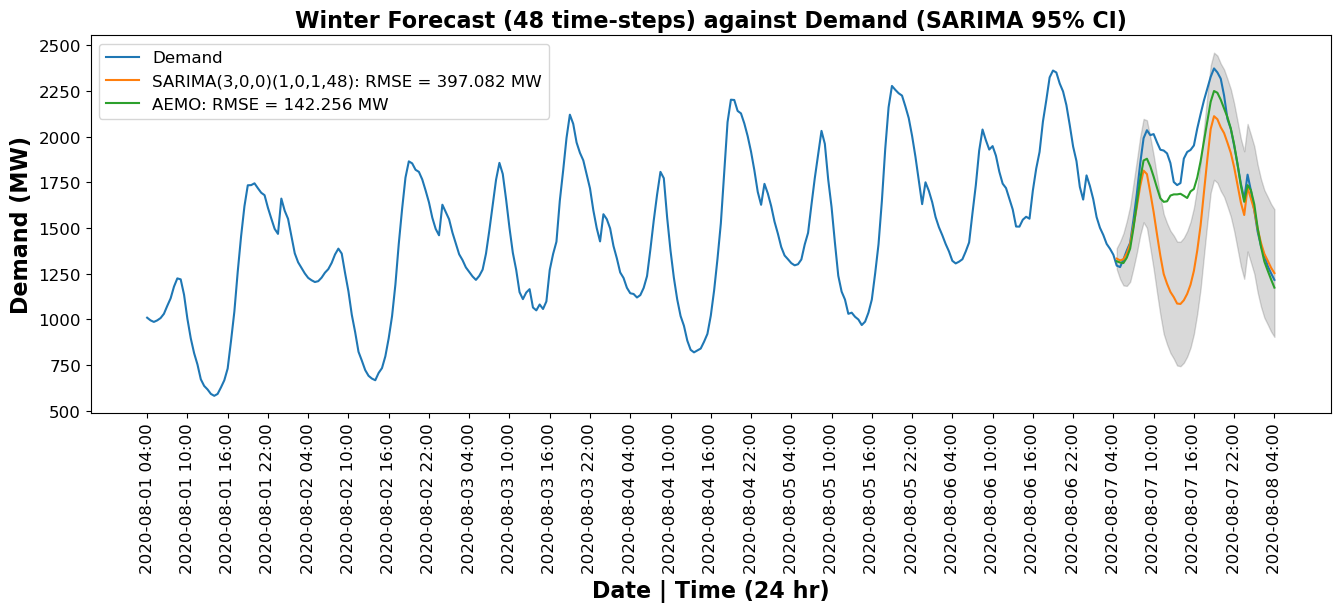

In [36]:
#Comparative demand forecast plot

figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_df['TIMEstrg'], truth_demand_df['TOTALDEMAND'], label='Demand')
plt_plot.plot(forecast_demand_time_df['TIMEstrg'], forecast_demand_time_df['FORECAST'], label='SARIMA(3,0,0)(1,0,1,48): RMSE = %.3f MW' % rmseARIMA)
plt_plot.plot(aemo_forecast_subset_df['TIMEstrg'], aemo_forecast_subset_df['FORECASTDEMAND'], label='AEMO: RMSE = %.3f MW' % rmseAEMO)

plt_plot.fill_between(ci_time_df['TIMEstrg'], ci_time_df['CI_LOWER'], ci_time_df['CI_UPPER'], color='k', alpha=.15)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')
#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::12])
plt_plot.set_xticklabels(xStrg[::12], rotation='vertical')
plt.title('Winter Forecast (48 time-steps) against Demand (SARIMA 95% CI)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='upper left', fontsize=12)
plt.savefig('WinterSARIMAPlot.png', bbox_inches='tight')
plt.show()

In [37]:
#Plot a sample of demand against model prediction

In [38]:
#Build final SARIMA model
#model2 = ARIMA(demand_sa_train_winter['TOTALDEMAND'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
#model2_fit = model2.fit()

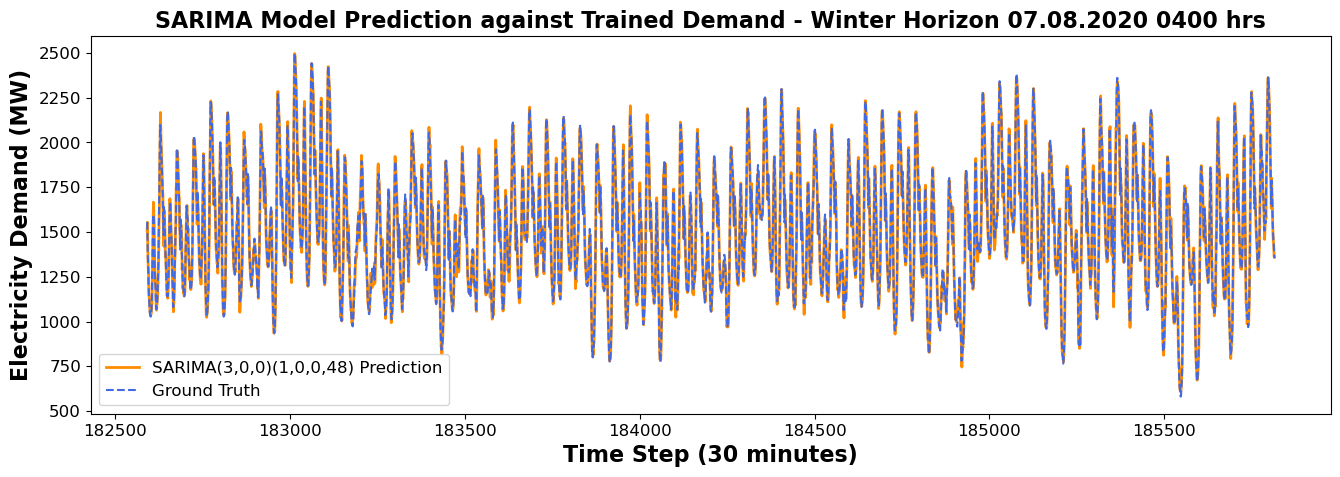

In [39]:
plt.figure(figsize=(16,5), dpi=100)
plt.plot(model_fit.predict(),color='darkorange', linewidth=2, label='SARIMA(3,0,0)(1,0,0,48) Prediction')
plt.plot(demand_sa_train_winter['TOTALDEMAND'],color='royalblue', label='Ground Truth', linestyle='dashed')
plt.title('SARIMA Model Prediction against Trained Demand - Winter Horizon 07.08.2020 0400 hrs', fontsize=16, fontweight='bold')
plt.tick_params(axis='both', labelsize=12)
plt.xlabel('Time Step (30 minutes)', fontsize=16, fontweight='bold')
plt.ylabel('Electricity Demand (MW)', fontsize=16, fontweight='bold')
plt.legend(loc='lower left', fontsize=12)
plt.savefig('TestSARIMAPlot.png', bbox_inches='tight')
plt.show()

In [40]:
#Investigate Temperature as an input to ARIMA to improve forecasts

#Load SA temperature and demand data
temp_sa_df = pd.read_csv('temprature_sa.csv')
demand_sa_df = pd.read_csv('totaldemand_sa.csv')

In [41]:
#Convert DATETIME string to type datetime 
demand_sa_df['DATETIME'] = pd.to_datetime(demand_sa_df['DATETIME'])

#Break down Timestamp into new attributes
demand_sa_df['YEAR'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).year
demand_sa_df['MONTH'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).month
demand_sa_df['DAY'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).day
demand_sa_df['TIME'] = pd.DatetimeIndex(demand_sa_df['DATETIME']).time

In [42]:
#Get preceding winter training data up to 7 Aug 0400 hrs 2020
iloc = (demand_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (demand_sa_df['DATETIME'] <= '2020-08-07 04:00:00')

#Create and capture winter training demand 2020
demand_sa_train_winter = demand_sa_df.loc[iloc]

In [43]:
#Get training winter temperatures
#Convert DATETIME string to type datetime 
temp_sa_df['DATETIME'] = pd.to_datetime(temp_sa_df['DATETIME'])
iloc = (temp_sa_df['DATETIME'] >= '2020-06-01 00:00:00') & (temp_sa_df['DATETIME'] <= '2020-08-07 04:00:00')
temp_sa_train_winter = temp_sa_df.loc[iloc]

In [44]:
#Check data sets same size
temp_sa_train_winter.shape

(3605, 4)

In [45]:
demand_sa_train_winter.shape

(3225, 7)

In [46]:
temp_sa_train_winter.head(25)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE
192995,192995,Adelaide (Kent Town),2020-06-01 00:00:00,12.4
192996,192996,Adelaide (Kent Town),2020-06-01 00:30:00,11.9
192997,192997,Adelaide (Kent Town),2020-06-01 01:00:00,13.0
192998,192998,Adelaide (Kent Town),2020-06-01 01:30:00,12.9
192999,192999,Adelaide (Kent Town),2020-06-01 02:00:00,12.3
193000,193000,Adelaide (Kent Town),2020-06-01 02:30:00,12.5
193001,193001,Adelaide (Kent Town),2020-06-01 03:00:00,13.4
193002,193002,Adelaide (Kent Town),2020-06-01 03:30:00,13.6
193003,193003,Adelaide (Kent Town),2020-06-01 04:00:00,13.0
193004,193004,Adelaide (Kent Town),2020-06-01 04:30:00,13.4


In [47]:
#Some temperatures not at 30 min intervals

#Break down Timestamp into new attributes
temp_sa_train_winter['MINUTES'] = pd.DatetimeIndex(temp_sa_train_winter['DATETIME']).minute

In [48]:
#Remove rows from Temp df where minutes != 0 or 30
minutes = [0, 30]
temp_sa_train_winter = temp_sa_train_winter[temp_sa_train_winter['MINUTES'].isin(minutes)]

In [49]:
temp_sa_train_winter.head(25)

,Unnamed: 0,LOCATION,DATETIME,TEMPERATURE,MINUTES
192995,192995,Adelaide (Kent Town),2020-06-01 00:00:00,12.4,0
192996,192996,Adelaide (Kent Town),2020-06-01 00:30:00,11.9,30
192997,192997,Adelaide (Kent Town),2020-06-01 01:00:00,13.0,0
192998,192998,Adelaide (Kent Town),2020-06-01 01:30:00,12.9,30
192999,192999,Adelaide (Kent Town),2020-06-01 02:00:00,12.3,0
193000,193000,Adelaide (Kent Town),2020-06-01 02:30:00,12.5,30
193001,193001,Adelaide (Kent Town),2020-06-01 03:00:00,13.4,0
193002,193002,Adelaide (Kent Town),2020-06-01 03:30:00,13.6,30
193003,193003,Adelaide (Kent Town),2020-06-01 04:00:00,13.0,0
193004,193004,Adelaide (Kent Town),2020-06-01 04:30:00,13.4,30


In [50]:
#Merge demand and temp df's fy datetime
demand_temp_df = pd.merge_asof(demand_sa_train_winter, temp_sa_train_winter, on='DATETIME', direction='forward')

In [51]:
#check null values
demand_temp_df[demand_temp_df.isna().any(axis=1)]

,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH,DAY,TIME,Unnamed: 0,LOCATION,TEMPERATURE,MINUTES


In [52]:
#Check for duplicate DATETIME
demand_temp_df.DATETIME.duplicated().sum()

0

In [53]:
#Check for NaN Temps
demand_temp_df['TEMPERATURE'].isnull().sum()

0

In [54]:
#Build SARIMA model with same settings as previously though input temperature to the model build
model2 = ARIMA(demand_temp_df[['TOTALDEMAND']], demand_temp_df[['TEMPERATURE']], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model2_fit = model2.fit()
model2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        TOTALDEMAND   No. Observations:                 3225
Model:             ARIMA(3, 0, 0)x(1, 0, [1], 48)   Log Likelihood              -15561.771
Date:                            Tue, 05 Apr 2022   AIC                          31139.541
Time:                                    13:26:33   BIC                          31188.171
Sample:                                         0   HQIC                         31156.969
                                           - 3225                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1705.7810    345.593      4.936      0.000    1028.431    2383.131
TEMPERATURE    -0.3821      0.214     -1.789      0.074      -0.801       0.036
ar.L1           1.4700      0.013    111.539      0.000       1.444       1.496
ar.L2          -0.4382      0.022    -19.969      0.000      -0.481      -0.395
ar.L3          -0.0641      0.013     -4.926      0.000      -0.090      -0.039
ar.S.L48        0.9994      0.000   5351.994      0.000       0.999       1.000
ma.S.L48       -0.9390      0.008   -118.031      0.000      -0.955      -0.923
sigma2        866.9562     14.132     61.348      0.000     839.259     894.654
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):              2169.17
Prob(Q):                              0.76   Prob(JB):                         0.00
Heteroskedasticity (H):               1.08   Skew:                             0.02
Prob(H) (two-sided):                  0.21   Kurtosis:                         7.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
#Get forecast winter temperatures
iloc = (temp_sa_df['DATETIME'] >= '2020-08-07 04:30:00') & (temp_sa_df['DATETIME'] <= '2020-08-08 04:00:00')
temp_sa_forecast_winter = temp_sa_df.loc[iloc]

#Some temperatures not at 30 min intervals

#Break down Timestamp into new attributes
temp_sa_forecast_winter['MINUTES'] = pd.DatetimeIndex(temp_sa_forecast_winter['DATETIME']).minute

#Remove rows from Temp df where minutes != 0 or 30
minutes = [0, 30]
temp_sa_forecast_winter = temp_sa_forecast_winter[temp_sa_forecast_winter['MINUTES'].isin(minutes)]

In [56]:
#Forecast 48 30min time steps with Temp
forecast_temp_48_ts = model2_fit.get_forecast(48, exog=temp_sa_forecast_winter['TEMPERATURE'], alpha=0.05).summary_frame()
#Evaluate winter demand 48 time steps forecasts
rmseARIMA_Temp = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], forecast_temp_48_ts['mean'])) 
print('RMSE Winter Demand Forecast (48 ts): %.3f MW' % rmseARIMA_Temp)

RMSE Winter Demand Forecast (48 ts): 398.742 MW


In [57]:
#Temperature as a variable is not significant at p=0.206 in explaining the variability in demand.

### 7 day average prediction model

In [114]:
#Get actual demand from 25.07.2020 0400 hrs til final prediction forcast time 31.07.2020 0400 hrs
iloc = (demand_sa_df['DATETIME'] > '2020-07-25 04:00:00') & (demand_sa_df['DATETIME'] <= '2020-07-31 04:00:00')
pre_forecast_6_day_demand_df = demand_sa_df.loc[iloc]

In [105]:
#Capture demand as list
pre_forecast_6_day_demand_lst = pre_forecast_6_day_demand_df['TOTALDEMAND'].tolist()

In [115]:
#Split demand list into 48 time steps list
pre_forecast_daily_demand_lst = [pre_forecast_6_day_demand_lst[i:i + 48] for i in range(0, len(pre_forecast_6_day_demand_lst), 48)]

In [116]:
# Create the pandas DataFrame to hold daily demand time steps
daily_demand_ts_df = pd.DataFrame(pre_forecast_daily_demand_lst, columns = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9', 'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19', 'T20', 'T21', 'T22', 'T23', 'T24', 'T25', 'T26', 'T27', 'T28', 'T29', 'T30', 'T31', 'T32', 'T33', 'T34', 'T35', 'T36', 'T37', 'T38', 'T39', 'T40', 'T41', 'T42', 'T43', 'T44', 'T45', 'T46', 'T47', 'T48',])

In [117]:
daily_demand_ts_df

,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,...,T39,40,T41,T42,T43,T44,T45,T46,T47,T48
0,1275.54,1266.63,1276.97,1302.87,1346.53,1408.68,1461.81,1530.26,1620.40,1588.93,...,1577.24,1748.92,1697.24,1629.55,1523.86,1453.54,1398.52,1366.66,1327.26,1296.67
1,1283.12,1278.61,1304.34,1319.44,1335.38,1368.56,1401.31,1449.36,1489.77,1486.02,...,1507.18,1684.76,1623.08,1570.26,1487.14,1422.12,1353.62,1325.53,1298.61,1253.37
2,1205.83,1230.59,1231.96,1273.95,1342.91,1465.35,1596.57,1732.93,1851.51,1827.27,...,1676.64,1827.33,1765.18,1699.92,1603.21,1527.87,1463.63,1430.81,1392.63,1358.98
3,1343.33,1347.70,1367.55,1423.13,1494.05,1659.71,1786.52,1960.05,2076.86,1988.80,...,1707.00,1855.95,1799.35,1731.42,1605.98,1508.40,1459.09,1442.72,1386.18,1355.91
4,1340.17,1330.00,1352.70,1394.35,1463.91,1592.16,1757.25,1924.38,2017.07,2004.80,...,1672.30,1819.81,1748.55,1689.19,1578.68,1498.23,1458.56,1417.41,1374.75,1359.65
5,1344.37,1351.16,1360.44,1411.16,1493.73,1629.91,1757.34,1897.63,1986.12,1938.51,...,1669.48,1802.82,1732.09,1667.68,1540.02,1441.71,1365.41,1312.63,1257.01,1219.98


In [118]:
#Add 48 time step prediction row to df
predict_series = pd.Series(forecast_48_ts['mean'].tolist(), index=daily_demand_ts_df.columns)
daily_demand_ts_df = daily_demand_ts_df.append(predict_series, ignore_index=True)

In [119]:
#Transpost df
daily_demand_ts_df_T = daily_demand_ts_df.T

In [120]:
#Define function to calculate time-step mean and 95% CI
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [121]:
#Add empty columns to df to hold time step mean and CI's
daily_demand_ts_df_T['Mean'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)
daily_demand_ts_df_T['lCI'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)
daily_demand_ts_df_T['uCI'] = daily_demand_ts_df_T.apply(lambda _: '', axis=1)

In [122]:
#Calculate time step means and CI's
daily_demand_ts_df_T[['Mean', 'lCI', 'uCI']] = daily_demand_ts_df_T.apply(lambda row : mean_confidence_interval([row[0],  row[1], row[2], row[3], row[4], row[5], row[6]]), axis = 1).values.tolist()

In [123]:
#Evaluate winter demand 48 time steps forecasts
rmse4DayAvForecast = sqrt(mean_squared_error(actual_demand_winter_2020_sa_48_ts_df['TOTALDEMAND'], daily_demand_ts_df_T['Mean'])) 
print('RMSE Winter Demand 4 Day AverageForecast (48 ts): %.3f MW' % rmse4DayAvForecast)

RMSE Winter Demand 4 Day AverageForecast (48 ts): 196.035 MW


In [102]:
daily_demand_ts_df_T

,0,1,2,3,4,5,Mean,lCI,uCI
T1,1283.12,1205.83,1343.33,1340.17,1344.37,1196.619538,1285.573256,1212.788297,1358.358215
T2,1278.61,1230.59,1347.70,1330.00,1351.16,1192.964167,1288.504028,1219.318212,1357.689844
T3,1304.34,1231.96,1367.55,1352.70,1360.44,1204.896772,1303.647795,1230.028036,1377.267555
T4,1319.44,1273.95,1423.13,1394.35,1411.16,1244.243257,1344.378876,1264.776727,1423.981025
T5,1335.38,1342.91,1494.05,1463.91,1493.73,1307.056105,1406.172684,1315.216006,1497.129362
T6,1368.56,1465.35,1659.71,1592.16,1629.91,1414.161609,1521.641935,1394.048131,1649.235739
T7,1401.31,1596.57,1786.52,1757.25,1757.34,1524.259817,1637.208303,1473.824649,1800.591957
T8,1449.36,1732.93,1960.05,1924.38,1897.63,1644.909291,1768.209882,1560.403469,1976.016294
T9,1489.77,1851.51,2076.86,2017.07,1986.12,1739.402368,1860.122061,1630.541839,2089.702283
T10,1486.02,1827.27,1988.80,2004.80,1938.51,1738.876913,1830.712819,1623.903713,2037.521925


### 17.03.2021 0000hrs to 2330 hrs Model Forecast

In [58]:
#Get 2021 data for model build
demand_sa_2021_df = demand_sa_df.loc[(demand_sa_df['YEAR'] == 2021)].reset_index()

#Get demand training data and forecast truth up to 18 March 00:00:00 2021 (inclusive)
iloc = (demand_sa_2021_df['DATETIME'] <= '2021-03-18 00:00:00')

#Create and capture summer demand 2021
demand_sa_summer_df = demand_sa_2021_df.loc[iloc]

In [59]:
#Subset summer training data
demand_sa_training_summer_df = demand_sa_summer_df.head(3600)

In [60]:
#Build final SARIMA model
model_summer = ARIMA(demand_sa_training_summer_df['TOTALDEMAND'], order=(3, 0, 0), seasonal_order=(1, 0, 1, 48))
model_summer_fit = model_summer.fit()

#summary of fitted model
model_summer_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        TOTALDEMAND   No. Observations:                 3600
Model:             ARIMA(3, 0, 0)x(1, 0, [1], 48)   Log Likelihood              -17864.388
Date:                            Tue, 05 Apr 2022   AIC                          35742.777
Time:                                    13:28:49   BIC                          35786.098
Sample:                                         0   HQIC                         35758.215
                                           - 3600                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1169.7419    396.604      2.949      0.003     392.413    1947.071
ar.L1          1.4499      0.009    159.628      0.000       1.432       1.468
ar.L2         -0.3199      0.017    -18.946      0.000      -0.353      -0.287
ar.L3         -0.1473      0.010    -14.111      0.000      -0.168      -0.127
ar.S.L48       0.9992      0.000   3315.494      0.000       0.999       1.000
ma.S.L48      -0.9559      0.007   -130.835      0.000      -0.970      -0.942
sigma2      1153.5407     15.085     76.468      0.000    1123.974    1183.107
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):              3697.70
Prob(Q):                              0.71   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
#Forecast 48 30min time steps
forecast_summer_48_ts = model_summer_fit.get_forecast(48, alpha=0.05).summary_frame()
print(forecast_summer_48_ts)

TOTALDEMAND         mean     mean_se  mean_ci_lower  mean_ci_upper
3600         1366.155676   33.965500    1299.584520    1432.726832
3601         1361.078081   59.824754    1243.823718    1478.332444
3602         1319.869222   85.112560    1153.051670    1486.686775
3603         1244.946283  108.333550    1032.616427    1457.276140
3604         1194.972118  129.284612     941.578935    1448.365301
3605         1164.610384  147.955206     874.623508    1454.597260
3606         1157.366205  164.488873     834.973938    1479.758472
3607         1138.214288  179.080508     787.222941    1489.205634
3608         1129.548619  191.939484     753.354144    1505.743094
3609         1125.427650  203.268613     727.028490    1523.826810
3610         1145.399876  213.254965     727.427825    1563.371928
3611         1169.434211  222.066338     734.192187    1604.676235
3612         1220.936221  229.850799     770.436933    1671.435509
3613         1274.118066  236.737749     810.120604    1738.11

In [62]:
#Capture 48 time steps of demand greater than forecast data
actual_demand_summer_2021_sa_48_ts_df = demand_sa_summer_df.tail(48)

#Generate time string for plotting
actual_demand_summer_2021_sa_48_ts_df['TIMEstrg'] = actual_demand_summer_2021_sa_48_ts_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

In [63]:
#Evaluate ARIMA summer demand 48 time steps forecasts
rmseARIMA_summer = sqrt(mean_squared_error(actual_demand_summer_2021_sa_48_ts_df['TOTALDEMAND'], forecast_summer_48_ts['mean'])) 
print('RMSE Summer Demand Forecast (48 ts): %.3f MW' % rmseARIMA_summer)

RMSE Summer Demand Forecast (48 ts): 96.637 MW


In [64]:
##Evaluate AEMO summer demand 48 time steps forecasts

#Load AEMO forecast for 17.03.2021 0030 hrs to 18.03.2021 0000hrs
aemo_summer_forecast_df = pd.read_csv('aemo_2021_forecast.csv')

#Convert DATETIME string to type datetime and change format for plotting
aemo_summer_forecast_df['DATETIME'] = pd.to_datetime(aemo_summer_forecast_df['DATETIME'])
aemo_summer_forecast_df['TIMEstrg'] = aemo_summer_forecast_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Evaluate AEMO summer  48 time steps forecasts
rmseAEMO_summer = sqrt(mean_squared_error(actual_demand_summer_2021_sa_48_ts_df['TOTALDEMAND'], aemo_summer_forecast_df['FORECASTDEMAND'])) 
print('RMSE AEMO Summer Winter Demand Forecast (48 ts): %.3f MW' % rmseAEMO_summer)

RMSE AEMO Summer Winter Demand Forecast (48 ts): 82.658 MW


In [65]:
#Prepare summer demand forecast data for plotting

#Get actual demand from 11.03.2021 1230 hrs til final prediction forcast time 18.03.2021 0000 hrs
iloc = (demand_sa_summer_df['DATETIME'] >= '2021-03-11 12:00:00') & (demand_sa_summer_df['DATETIME'] <= '2021-03-18 23:30:00')
truth_demand_sa_summer_df = demand_sa_summer_df[iloc]
truth_demand_sa_summer_df['TIMEstrg'] = demand_sa_summer_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get and prepare 48 time step forecast summer demand between 17.03.2021 0030 hrs and 18.03.2021 0000 hrs 
forecast_summer_series = forecast_summer_48_ts['mean'].reset_index(drop=True)
summer_time_series = actual_demand_summer_2021_sa_48_ts_df['DATETIME'].reset_index(drop=True)
summer_forecast_demand_time_df = pd.concat([forecast_summer_series, summer_time_series], axis=1).rename(columns={'mean': 'FORECAST', 'DATETIME': 'TIME'})
summer_forecast_demand_time_df['TIMEstrg'] = summer_forecast_demand_time_df['TIME'].dt.strftime('%Y-%m-%d %H:%M')

#Get forecast upper and lower CI's between 17.03.2021 0000 hrs and 17.03.2021 2330 hrs
summer_lower_ci_series = forecast_summer_48_ts['mean_ci_lower'].reset_index(drop=True)
summer_upper_ci_series = forecast_summer_48_ts['mean_ci_upper'].reset_index(drop=True)
summer_ci_time_df = pd.concat([summer_lower_ci_series, summer_upper_ci_series, summer_time_series], axis=1).rename(columns={'mean_ci_lower': 'CI_LOWER', 'mean_ci_upper': 'CI_UPPER','TIME': 'TIME'})
summer_ci_time_df['TIMEstrg'] = summer_ci_time_df['DATETIME'].dt.strftime('%Y-%m-%d %H:%M')

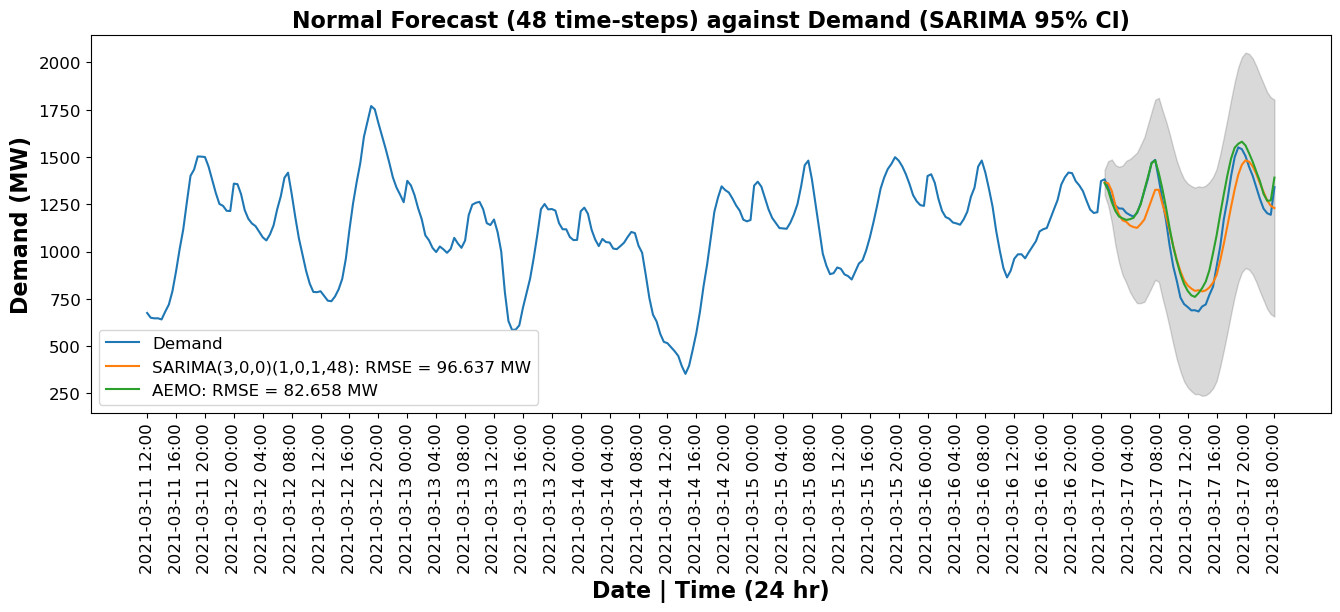

In [67]:
#Comparative summer demand forecast plot
figure = plt.figure(figsize=(16,5), dpi=100)
plt_plot = figure.add_subplot(111)

plt_plot.plot(truth_demand_sa_summer_df['TIMEstrg'], truth_demand_sa_summer_df['TOTALDEMAND'], label='Demand')
plt_plot.plot(summer_forecast_demand_time_df['TIMEstrg'], summer_forecast_demand_time_df['FORECAST'], label='SARIMA(3,0,0)(1,0,1,48): RMSE = %.3f MW' % rmseARIMA_summer)
plt_plot.plot(aemo_summer_forecast_df['TIMEstrg'], aemo_summer_forecast_df['FORECASTDEMAND'], label='AEMO: RMSE = %.3f MW' % rmseAEMO_summer)

#Plot CI's
plt_plot.fill_between(summer_ci_time_df['TIMEstrg'], summer_ci_time_df['CI_LOWER'], summer_ci_time_df['CI_UPPER'], color='k', alpha=.15)

#plt.xticks(rotation='vertical')
plt.xlabel('Date | Time (24 hr)', fontsize=16, fontweight='bold')
plt.ylabel('Demand (MW)', fontsize=16, fontweight='bold')

#Change xaxis string label frequency to prevent overlap
xStrg = truth_demand_sa_summer_df['TIMEstrg']
plt.tick_params(axis='both', labelsize=12)
plt_plot.set_xticks(xStrg[::8])
plt_plot.set_xticklabels(xStrg[::8], rotation='vertical')

plt.title('Normal Forecast (48 time-steps) against Demand (SARIMA 95% CI)', fontsize=16, fontweight='bold')
plt_plot.legend(loc='lower left', fontsize=12)
plt.savefig('NormalSARIMAPlot.png', bbox_inches='tight')
plt.show()

In [47]:
demand_sa_summer_df.tail()

,index,DATETIME,TOTALDEMAND,REGIONID,YEAR,MONTH
3643,196506,2021-03-17 21:30:00,1338.72,SA1,2021,3
3644,196507,2021-03-17 22:00:00,1277.91,SA1,2021,3
3645,196508,2021-03-17 22:30:00,1226.81,SA1,2021,3
3646,196509,2021-03-17 23:00:00,1202.62,SA1,2021,3
3647,196510,2021-03-17 23:30:00,1194.34,SA1,2021,3
